In [2]:
# Simple LFMM without stochastic volatility 
# Modelling the LIBOR Forward Market Model widely considered benchmark model like the Black Scholes 
# Models financial instruments traded in the market is more ideal unlike short_rate model
# Results in analytic price for market caps
# Can easily be calculated using observable market instruments
# Deals with aspect continous rates not directly observable in the markets
# Disadvantage - many forward rates existing in financial markets

In [3]:
# Simulating bond prices using LFMM
# Will find forward rates, then market capitalisation factors, invert the cap factors to get discount rates
# We use market prices for bond or generate own synthetic bond prices e.g using vasicek model 

In [2]:
# Import modules 
import math
import numpy as np
from scipy.stats import norm
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [3]:
# Model parameters and dynamics
r_0   = 0.05   # initial r(0) starting/known interest rate 
alpha = 0.2    # rate at which short rate tends toward long-term average
b     = 0.08   # long-term average short rate
sigma = 0.025  # volatility of short rate
sigmaj = 0.2   # assume constant volatility forward rates over time

# Monte Carlo Simulation dynamics
np.random.seed(0)
num_simulations = 100000
t               = np.linspace(0,40,21) #finding forward rates 2 years apart for 40 year period
num_steps       = len(t) # number of time steps we are simulating over 

In [4]:
# Analytical bond prices functions based off closed form Vasicek model
def A_t_T(t1,t2):
    return (1 - np.exp(-alpha*(t2-t1)))/alpha

def D_t_T(t1,t2):
    val1 = (sigma**2/(2*alpha**2)-b)*(-A_t_T(t1,t2)+ t2-t1)
    val2 = sigma**2*A_t_T(t1,t2)**2/(4*alpha)
    return val1-val2
    
def bond_price(r_t,t,T):
    return np.exp(-A_t_T(t,T)*r_t + D_t_T(t,T))

vasi_bond_price = bond_price(r_0,0,t)

array([1.        , 0.89590226, 0.79169223, 0.69410022, 0.60568138,
       0.52700054, 0.45770755, 0.39706245, 0.34419188, 0.29821302,
       0.25829143, 0.22366539, 0.19365315, 0.16765184, 0.14513226,
       0.12563216, 0.10874895, 0.09413279, 0.08148002, 0.07052735,
       0.06104659])

In [5]:
# Initialize Fj from existing bond prices using Fj(t_0) = (Pj(0)-Pj+1(0)) / (delta_j*Pj+1(0)) delta_j = Tj+1 - Tj
mc_forward     = np.ones([num_simulations,num_steps-1])*((vasi_bond_price[:-1]-vasi_bond_price[1:])/(2*vasi_bond_price[1:]))

# Initialize predictor-corrector forwards 
predcorr_forward = np.ones([num_simulations,num_steps-1])*((vasi_bond_price[:-1]-vasi_bond_price[1:])/(2*vasi_bond_price[1:]))

#Initialize predictor corrector and normal capitalization factor
mc_capfactor        = np.ones([num_simulations, num_steps])
predcorr_capfactor  = np.ones([num_simulations, num_steps])

delta=np.ones([num_simulations,num_steps-1])*(t[1:]-t[:-1])

In [21]:
# Implementing Monte Carlo Simulation for formulate forward rates
for i in range(1,num_steps):
    Z = norm.rvs(size = [num_simulations, 1])
    
    # Explicit Monte Carlo Simulation
    muhat=np.cumsum(delta[:,i:]*mc_forward[:,i:]*sigmaj**2/(1+delta[:,i:]*mc_forward[:,i:]),axis=1)
    mc_forward[:,i:]=mc_forward[:,i:]*np.exp((muhat-sigmaj**2/2)*delta[:,i:]+sigmaj*np.sqrt(delta[:,i:])*Z)
    
    # Predictor-Corrector Monte Carlo Simulation
    mu_initial=np.cumsum(delta[:,i:]*predcorr_forward[:,i:]*sigmaj**2/(1+delta[:,i:]*predcorr_forward[:,i:]),axis=1)
    for_temp=predcorr_forward[:,i:]*np.exp((mu_initial-sigmaj**2/2)*delta[:,i:]+sigmaj*np.sqrt(delta[:,i:])*Z)
    mu_term=np.cumsum(delta[:,i:]*for_temp*sigmaj**2/(1+delta[:,i:]*for_temp),axis=1)
    predcorr_forward[:,i:]=predcorr_forward[:,i:]*np.exp((mu_initial+mu_term-sigmaj**2)*delta[:,i:]/2+sigmaj*np.sqrt(delta[:,i:])*Z)   
    

In [42]:
# Implying capitalisation factors from the forward rates
mc_capfactor[:,1:]      =  np.cumprod(1+delta*mc_forward,axis=1)
predcorr_capfactor[:,1:]=  np.cumprod(1+delta*predcorr_forward,axis=1)

# Inversting the capitalisation factors to imply bond prices (discount factors)
mc_price=mc_capfactor**(-1)
predcorr_price=predcorr_capfactor**(-1)

# Taking averages to find implied prices under the two different models
mc_final_prices=np.mean(mc_price,axis=0)
predcorr_final_prices=np.mean(predcorr_price,axis=0)

# Getting the annualized implied forward rates 
forwards_vasicek = ((vasi_bond_price[:-1]-vasi_bond_price[1:])/(2*vasi_bond_price[1:]))
forwards_mc      = ((mc_final_prices[:-1]-mc_final_prices[1:])/(2*mc_final_prices[1:]))
forwards_predcorr= ((predcorr_final_prices[:-1]-predcorr_final_prices[1:])/(2*predcorr_final_prices[1:]))

t[:-1]
                                                          

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
       26., 28., 30., 32., 34., 36., 38.])

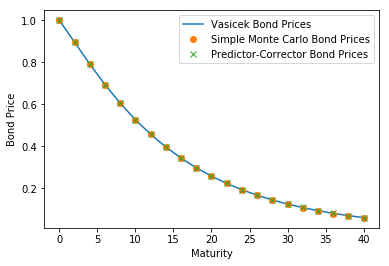

In [30]:
# Plotting results
plt.xlabel("Maturity")
plt.ylabel("Bond Price")
plt.plot(t,vasi_bond_price,label="Vasicek Bond Prices")
plt.plot(t,mc_final_prices,'o',label="Simple Monte Carlo Bond Prices")
plt.plot(t,predcorr_final_prices,'x',label="Predictor-Corrector Bond Prices")
plt.legend()
plt.show()

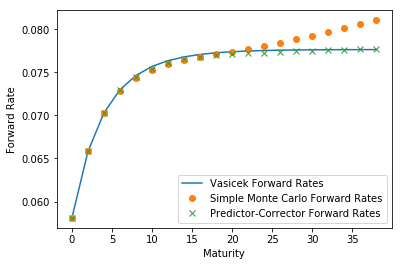

In [44]:
# Plot 2 year forward rates implied by the bond prices
plt.xlabel("Maturity")
plt.ylabel("Forward Rate")
plt.plot(t[:-1],forwards_vasicek,label="Vasicek Forward Rates")
plt.plot(t[:-1],forwards_mc,'o',label="Simple Monte Carlo Forward Rates")
plt.plot(t[:-1],forwards_predcorr,'x',label="Predictor-Corrector Forward Rates")
plt.legend()
plt.show()